# Data Science Assignment_1 

<table>
    <tr><td><b>Name : Ridhi Sharma</b></td></tr>
    <tr><td><b>Student Number : 21201977</b></td></tr>
    <tr><td><b>Review DB URL : http://mlg.ucd.ie/modules/python/assign2/21201977/"</b></td></tr>
</table>

The objective of this assignment is to scrape a collection of product reviews from a set of web pages, preprocess the data, and evaluate the performance of different classifiers in the context of two related text classification tasks: (i) predicting review sentiment; (ii) predicting review helpfulness.

### This notebook covers Task 2 -  Review Sentiment Classification and Task 3 -  Review Helpfulness Classification.

In this notebook, we are going to first assign class values according to ratings and helpfulness information given to us and then train the model based on different binary classifiers.<br>
We will be analyzing the below steps:<br>
**1. Text preprocessing:** <br>
    a. This we will do by filtering the text documents<br>
    b. Applying a custom tokenizer to handle stemming and lemming<br>
    c. Applying vectorization of two types count and tfidf<br>
**2. Classification:** <br>
    a. Hold-out Strategy, for this we will create a train-test split apply the model on a training set, and predict the results of testing data test.<br>
    b. Cross-Validation, in this we will take the whole data set and perform 'n' number of folds and calculate the accuracy.<br>
    c. Pipe-line, this a method where we can combine the text pre-processing and classification.<br>
**3. Comparision** <br> 
    Then we would be comparing different classifiers using the above techniques for Sentiment and Helpfulness Classification

In [1]:
#libraries used
from pathlib import Path
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.stem.porter import PorterStemmer
%matplotlib inline

Path to read review.csv

In [2]:
# directory for raw data storage
dir_raw = Path("raw")
filePath_raw = dir_raw/"reviwes.csv"

Below code is used to allign the plots in the centre of the notebook

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

First we read the .csv file as a dataframe which will simplify our analysis further

In [4]:
dataframe_reviews = pd.read_csv(filePath_raw) 

## Part-2 Sentiment Analysis

### Assigning Class Labels

Defined a function to assign sentiments based on the rating, we were provided with the information to assume that 1-star to 3-star reviews are “negative”, and 4-star to 5-star reviews are “positive”.

In [5]:
def assign_sentiments(df):
    Sentiments = []
    for row in df["Rating"]:
        if row < 3: Sentiments.append("Negative")
        else: Sentiments.append("Postive")
    df['Sentiments'] = Sentiments
    return df

We now create a new data frame with Sentiment values for Part-2 Analysis.

In [6]:
#save this data frame for sentiments for each analysis
df_reviews_sentiments= assign_sentiments(dataframe_reviews)

In [7]:
df_reviews_sentiments[0:4]

,Main Title,Review Title,Rating,Helpfulness Information,Review Body,Sentiments
0,Product Reviews Archive January 2016,The herbs were great...but the cherry tomatoes...,2,88.235294,The herb kit that came with my Aerogarden was ...,Negative
1,Product Reviews Archive January 2016,Even more useful than regular parchment paper,5,100.000000,I originally bought this just because it was c...,Postive
2,Product Reviews Archive January 2016,Shake it before you bake it,2,15.384615,"If you do it in reverse (bake before shaking),...",Negative
3,Product Reviews Archive January 2016,Not what the picture describes,2,50.000000,I bought this steak for my father in law for C...,Negative


Now we create a data frame as a set of documents, where each row is a concatenation of the review’s title and body text and has a class value same as sentiments. This will be our main data set to deal with for Part-2

In [8]:
#define a new data frame for classification
df_text_sentiments = pd.DataFrame({"Review Text": df_reviews_sentiments["Review Title"]+" "+df_reviews_sentiments["Review Body"]
                            ,"Class":df_reviews_sentiments["Sentiments"]})
df_text_sentiments[0:4]

,Review Text,Class
0,The herbs were great...but the cherry tomatoes...,Negative
1,Even more useful than regular parchment paper ...,Postive
2,Shake it before you bake it If you do it in re...,Negative
3,Not what the picture describes I bought this s...,Negative


For classification purpose we need a list of documents and the class labels as separate variables to handle and for easy representation.

In [69]:
# the corresponding documents and class labels to use for classification
documents_sentiments = df_text_sentiments["Review Text"]
target_names_sentiments = df_text_sentiments["Class"].values

### Text Analysis - Tokenizing Text and Bag of words representation
Tokenization helps in creating tokens for words and also removes unwanted punctuation from the text, as for us in this analysis we don't care if there are any punctuation. But this may not a case for every analysis. 

In [10]:
#just to check the types of words which are present in the document
doc1= documents_sentiments[0]
tokenize = CountVectorizer().build_tokenizer()
# convert to lowercase, then tokenize
tokens1 = tokenize(doc1.lower())
print(tokens1)

['the', 'herbs', 'were', 'great', 'but', 'the', 'cherry', 'tomatoes', 'not', 'so', 'great', 'the', 'herb', 'kit', 'that', 'came', 'with', 'my', 'aerogarden', 'was', 'superb', 'and', 'enjoyed', 'caring', 'for', 'my', 'little', 'garden', 'once', 'it', 'was', 'time', 'to', 'replace', 'it', 'purchased', 'the', 'cherry', 'tomato', 'seed', 'kit', 'these', 'also', 'grew', 'rapidly', 'but', 'one', 'day', 'noticed', 'that', 'they', 'had', 'completely', 'fallen', 'over', 'how', 'would', 'stake', 'these', 'on', 'an', 'aerogarden', 'and', 'yes', 'the', 'lights', 'were', 'as', 'close', 'to', 'the', 'plants', 'as', 'possible', 'kind', 'of', 'leaned', 'them', 'against', 'each', 'other', 'to', 'keep', 'them', 'upright', 'but', 'they', 'still', 'fell', 'over', 'several', 'times', 'so', 'they', 'grew', 'and', 'grew', 'but', 'never', 'got', 'any', 'tomatoes', 'also', 'did', 'follow', 'the', 'directions', 'to', 'ensure', 'that', 'they', 'had', 'complete', 'darkness', 'for', 'proper', 'flowering', 'fortuna

We can see that many of the words here are not useful (e.g. "to", "the" etc.). So we remove such words using a list of such *stop words* which is provided by scikit-learn:

In [11]:
#defining stop words
stopwords = text.ENGLISH_STOP_WORDS

But now before tokenizing the docucment again, we will filter the document as there are many words like "ha", "te", which are really not useful, so we remove these words by checking the lenght of words and words having lenght less than 2 have been removed, we have also observed that there are unwanted numbers which we have removed by using re.sub by passing a regex.

In [12]:
#definition to filter documents.
def filter_doc(doc):
    filtered_document=[]
    for sen in range(0, len(doc)):
        #removing numbers, words with any numbers and extra spaces.
        document= re.sub(r'[0-9]+', ' ',doc[sen])
        document = re.sub(r'\s+', ' ', document, flags=re.I)
        # Converting to Lowercase
        document = document.lower()  
        document = document.split()
        #removing words less than 2 letters.
        document = ' '.join([w for w in document if len(w)>2])
        filtered_document.append(document)
    print("Created %d filtered document lists" % len(filtered_document) )
    return filtered_document

We now store this document as filtered document, we can use this similar function for part-3 as well.

In [13]:
#set of filtered documents
filtered_document_senti=filter_doc(documents_sentiments)

Created 9244 filtered document lists


Now we tokenize the whole set of documents and store this tokens as filtered tokens.

### Text Preprocessing and Classification

So firstly, when trying to stem the documents using CountVectorizering the set of documents had a few stop words felt that were not consistent and were not been removed while vectorizing the text, so for this we need to include those stop words into our tokenization process and then remove it later. <br>
**CountVectorizer** is used to convert text into a vector based on the frequency or count of each word.

**Stemming**: Stemming is a process to reduce the word its root by removing a part of it, for example, if we have ask, asked and asking it will remove the ending as 'ed' and 'ing' and convert both of them to 'ask'.

In [14]:
# define the function for stemming
def stem_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = CountVectorizer().build_tokenizer()
    #create tokens based on countVectorizer
    tokens = standard_tokenizer(text)
    # then use NLTK to perform stemming on each token
    stemmer = PorterStemmer()
    filtered_tokens=[]
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
     # to remove stopwords with tokenization
    stems = [stemmer.stem(t) for t in filtered_tokens if t not in stopwords]
    return stems

### Term Frequency Analysis

We now define our CountVectorize function based on our stem tokenizer we have also removed words with frequency less than 10.

We also create a vectorize data data set for term frequency analysis and this can be used futher for applying ***cross validation*** as well

In [15]:
#vectorize the filetered documents
vectorizer_senti = CountVectorizer(stop_words="english", min_df = 10, tokenizer=stem_tokenizer)
X_data_senti = vectorizer_senti.fit_transform(filtered_document_senti)
print(X_data_senti.shape)

(9244, 4161)


In [16]:
#Count the terms in vectoried document
terms_senti = vectorizer_senti.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms_senti))

Vocabulary has 4161 distinct terms


### Measuring Similarity

We can now measure the similarity of document, as part of test analysis, using finding the cosine angle between two documents.

In [17]:
# first document - just display the start of it
print(filtered_document_senti[0])

the herbs were great...but the cherry tomatoes...not great the herb kit that came with aerogarden was superb and enjoyed caring for little garden. once was time replace it, purchased the cherry tomato seed kit. these also grew rapidly, but one day noticed that they had completely fallen over...how would stake these aerogarden? and yes, the lights were close the plants possible. kind leaned them against each other keep them upright. but they still fell over several times. they grew and grew but never got any tomatoes. also did follow the directions ensure that they had complete darkness for proper flowering. fortunately have several tomato and cherry tomato plants our outdoor vegetable garden. unfortunately, spent cherry tomato aerogarden plants and got zero yield.


We will have to vectorize our document to filter out the unwanted words and then and then measure the similarity based on those vectorized documents.

In [18]:
# measure the cosine similarity between the first document vector and all of the other document vectors
max_cos = 0
best_row = 0
for row in range(1,X_data_senti.shape[0]):
    cos = cosine_similarity(X_data_senti[0], X_data_senti[row])
    # best so far?
    if cos > max_cos:
        max_cos = cos
        best_row = row

In [19]:
print("Most similar document was row %d: cosine similarity = %.3f" % (best_row, max_cos) )

Most similar document was row 24: cosine similarity = 0.528


In [20]:
# most similar document - just display the start of it
print(filtered_document_senti[best_row])

looks like cherry tomato reviews are negative working second cherry tomato seed kit. after about three months, the first crop provided about eight cherry tomatoes. hardly bumper crop. during the growth had clean out the pump which got clogged with roots (more that latter). figured, ok, had disturb the root system when had clean out the pump, perhaps that was the problem. started second crop cherry tomatoes about three months ago. far, have had one marble sized yellow tomato. also have additional two, marble sized, yellow tomatoes ripening. have not even seen any flowers the two red tomato plants. the red tomato plants grow, but tomato production. running out plant nutrients. checked aerogrows site, and they want ridiculous price for additional package plant nutrients. corporate greed its worse. have read all the reviews, and see that about one-third the cherry tomato reviews are positive. that leaves two-thirds cherry tomato reviews negative. adding negative cherry tomato review drops 

### Train and Test Data Creation

We now create training data and testing data, using train_test_split function with a **train-test split as 20%**

In [21]:
#train-test split
train_data_senti, test_data_senti, train_target_senti, test_target_senti = train_test_split(filtered_document_senti, 
                                                                                            target_names_sentiments, 
                                                                                            test_size=0.2)

In [22]:
print("Training set has %d documents. Target classes are %s" % (len(train_data_senti), set(train_target_senti)))

Training set has 7395 documents. Target classes are {'Postive', 'Negative'}


In [23]:
print("Test set has %d documents. Target classes are %s" % (len(test_data_senti), set(test_target_senti)))

Test set has 1849 documents. Target classes are {'Postive', 'Negative'}


### Train and Test Data Vectorization

We now vectorize the training and the test data set as CountVectorization

In [24]:
#vectorize training data
X_train_senti = vectorizer_senti.fit_transform(train_data_senti)
print(X_train_senti.shape)

(7395, 3694)


In [25]:
print(list(vectorizer_senti.vocabulary_.keys())[0:35])

['popcorn', 'perfect', 'littl', 'year', 'old', 'son', 'love', 'concern', 'hull', 'potenti', 'choke', 'hazard', 'true', 'free', 'come', 'close', 'tast', 'great', 'opinion', 'kid', 'friendli', 'brand', 'use', 'machin', 'home', 'miss', 'flour', 'lot', 'dens', 'heavier', 'expect', 'make', 'difficult', 'bake', 'decent']


For test data we just perform transform to keep the same number of columns of words

In [26]:
#vectorize testing data
X_test_senti = vectorizer_senti.transform(test_data_senti)
print(X_test_senti.shape)

(1849, 3694)


### Cross Validation CV=5
<br>So firstly, we will apply a cross-validation technique using KNN, which can help us analyze which value of K might be better to take into consideration.

In [27]:
#cross validation for KNN
for k in [1,3,5]:
    model = KNeighborsClassifier(n_neighbors=k)
    # apply 5-fold cross-validation, measuring accuracy each time
    acc_scores = cross_val_score(model, X_data_senti, target_names_sentiments, cv=5, scoring="accuracy")
    # get the mean accuracy across 5 folds
    mean_acc = acc_scores.mean()
    print("K=%d - Mean accuracy=%.3f" % (k,mean_acc) )

K=1 - Mean accuracy=0.744
K=3 - Mean accuracy=0.730
K=5 - Mean accuracy=0.723


### KNN=3 using Hold-out Startergy
We will now build KNN using K= 3, as K = 1 is not ideal and K=5 has less accuracy and calculate the accuracy and other methods of accuracy for this model.

In [28]:
# build a KNN model on the document-term matrix created from the original set of documents
model_KNN_senti = KNeighborsClassifier(n_neighbors=3)
model_KNN_senti.fit(X_train_senti, train_target_senti)

KNeighborsClassifier(n_neighbors=3)

In [29]:
#Predicted KNN class values
predicted_Senti_KNN = model_KNN_senti.predict(X_test_senti)

In [30]:
#Accuracy for KNN
acc_KNN = accuracy_score(test_target_senti, predicted_Senti_KNN)
print("Classification accuracy = %.3f" % acc_KNN)

Classification accuracy = 0.735


In [31]:
#setting target categories
target_categories_senti = ["Positive","Negative"]

In [32]:
#prints classification report with all the accuracy metrics
print(classification_report(test_target_senti, predicted_Senti_KNN, target_names=target_categories_senti))

              precision    recall  f1-score   support

    Positive       0.60      0.74      0.66       657
    Negative       0.83      0.73      0.78      1192

    accuracy                           0.73      1849
   macro avg       0.72      0.74      0.72      1849
weighted avg       0.75      0.73      0.74      1849



**Comment:** We can see that the **accuracy is 73.5%** for KNN=3, while we can see that the **precision is less for positive class**, which means the model had difficulty predicting positive class, maybe because the **number of positives must be less than negatives**. While the recall is quite similar for both the classes stating the model was able to cover these classes properly.

This being a binary classifier, Precision and Recall plays an important role where,<br>
1. **Precision** is the number of correct positive outcomes divided by the classifier's predicted number of positive results.
2. **Recall** is calculated by dividing the number of valid positive results by the total number of relevant observations.

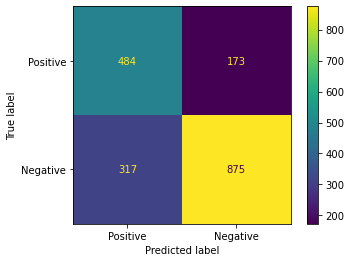

In [33]:
# calculate the confusion matrix
cm_KNN = confusion_matrix(test_target_senti, predicted_Senti_KNN)
# display it graphically
cmd = ConfusionMatrixDisplay(cm_KNN, display_labels=target_categories_senti)
cmd.plot();

**Comment:** As the precision was low for the positive class we can see from the confusion matrix that higher number positives were predicted as negatives. The model works good for negative classes but not great for the positive class.

### Cross Validation CV=10

As we can see that the accuracy comes out to be similar, for K=3 for cross-validation and normal KNN. We can also check that if we increase the folds of the cross validation how our model would work.

In [34]:
#cross validation using KNN
for k in [1,3,5]:
    model = KNeighborsClassifier(n_neighbors=k)
    # apply 10-fold cross-validation, measuring accuracy each time
    acc_scores = cross_val_score(model, X_data_senti, target_names_sentiments, cv=10, scoring="accuracy")
    # get the mean accuracy across 5 folds
    mean_acc = acc_scores.mean()
    print("K=%d - Mean accuracy=%.3f" % (k,mean_acc) )

K=1 - Mean accuracy=0.754
K=3 - Mean accuracy=0.737
K=5 - Mean accuracy=0.731


**Comment:** This increases the accuracy but not to that extent so it is better to use 5 folds as using a high number of folds is time-consuming, but if we have large datasets we should try checking 10-cross-fold validation

### Pipeline Classification using SVM<br>
Pipeline helps in doing every step together, like data preperation(tokenization) and classification. So below we created a pipeline using SVM classifier and the tokenizer we defined above.

In [35]:
#SVM pipeline model
pipeline_svm_senti = Pipeline([
    ('vec', CountVectorizer(stop_words="english", min_df = 10, tokenizer=stem_tokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])

In [36]:
#fit SVM model
pipeline_svm_senti.fit(train_data_senti, train_target_senti)

Pipeline(steps=[('vec',
                 CountVectorizer(min_df=10, stop_words='english',
                                 tokenizer=<function stem_tokenizer at 0x000001C802E0C9D0>)),
                ('tfidf', TfidfTransformer()), ('clf', SGDClassifier())])

In [37]:
#predict target class
predicted_SVM_Senti = pipeline_svm_senti.predict(test_data_senti)
print("Classification accuracy = %.3f" % accuracy_score(test_target_senti, predicted_SVM_Senti))

Classification accuracy = 0.884


In [38]:
#prints classification report with all the accuracy metrics
print(classification_report(test_target_senti, predicted_SVM_Senti, target_names=target_categories_senti))

              precision    recall  f1-score   support

    Positive       0.86      0.81      0.83       657
    Negative       0.90      0.92      0.91      1192

    accuracy                           0.88      1849
   macro avg       0.88      0.87      0.87      1849
weighted avg       0.88      0.88      0.88      1849



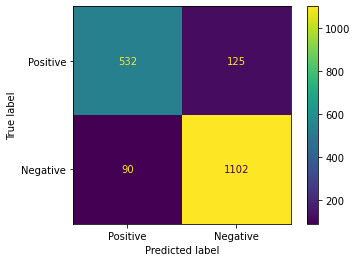

In [39]:
# calculate the confusion matrix
cm_SVM = confusion_matrix(test_target_senti, predicted_SVM_Senti)
# display it graphically
cmd = ConfusionMatrixDisplay(cm_SVM, display_labels=target_categories_senti)
cmd.plot();

**Comment:** SVM showed high accuracy when compared to KNN because, it defines the best boundary to separate the class, which enhances itself as a model when compared to others, as we can see that the wrongly classified classes are less in SVM as compared to KNN and precision and recall is also great. 

## Part 3-  Review Helpfulness Classification 

In part of the assignment we will try to work with Helpfulness classification using similar analysis and change if we think we would need some better methods.

So, first, we define a function to assign the helpfulness value, for this I assumed if the percentage of helpfulness information is more than 60% then that review is considered helpful. This percentage was sent will collection data itself.

In [40]:
#function to assign helpfulness
def assign_helpfulness(df):
    Helpfulness = []
    for row in df["Helpfulness Information"]:
        if row < 60: Helpfulness.append("Not Helpful")
        else: Helpfulness.append("Helpful")
    df['Helpfulness'] = Helpfulness
    return df

In [41]:
#store this data frame as new dataframe for analysis
df_reviews_helpfullness= assign_helpfulness(dataframe_reviews)

In [42]:
df_reviews_helpfullness[0:4]

,Main Title,Review Title,Rating,Helpfulness Information,Review Body,Sentiments,Helpfulness
0,Product Reviews Archive January 2016,The herbs were great...but the cherry tomatoes...,2,88.235294,The herb kit that came with my Aerogarden was ...,Negative,Helpful
1,Product Reviews Archive January 2016,Even more useful than regular parchment paper,5,100.000000,I originally bought this just because it was c...,Postive,Helpful
2,Product Reviews Archive January 2016,Shake it before you bake it,2,15.384615,"If you do it in reverse (bake before shaking),...",Negative,Not Helpful
3,Product Reviews Archive January 2016,Not what the picture describes,2,50.000000,I bought this steak for my father in law for C...,Negative,Not Helpful


Now we create the same kind of document array with the concatenation of review body and text alongside the Helpfulness class.

In [43]:
df_text_helpfulness = pd.DataFrame({"Review Text": df_reviews_sentiments["Review Title"]+" "+df_reviews_sentiments["Review Body"]
                            ,"Class":df_reviews_sentiments["Helpfulness"]})
df_text_helpfulness[0:4]

,Review Text,Class
0,The herbs were great...but the cherry tomatoes...,Helpful
1,Even more useful than regular parchment paper ...,Helpful
2,Shake it before you bake it If you do it in re...,Not Helpful
3,Not what the picture describes I bought this s...,Not Helpful


Now we create a list of documents to vectorize further.

In [44]:
documents_helpfulness = df_text_helpfulness["Review Text"]
# the corresponding class labels to use for training
target_names_help = df_text_helpfulness["Class"].values

Using the same function for sentiment analysis we clean our document and filter out the unnecessary words, this is similar to what we are getting for sentiment analysis but we are just giving it a different name for easy use.

In [45]:
#fitered documents.
filtered_help_doc= filter_doc(documents_helpfulness)

Created 9244 filtered document lists


Hence we don't need to check the tokenization, token counts and term frequency for the same document.

For helpfulness analysis, we have used lemmatization as a token technique using TfidfVectorizer vectorization converts which text to feature vectors.

**Lemming:** Lemming means performing things correctly with the help of a vocabulary and canonical evaluation of words.

In [46]:
# define the function for lemming
def lemma_tokenizer(text):
    # use the standard scikit-learn tokenizer first
    standard_tokenizer = TfidfVectorizer().build_tokenizer()
    tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
    lemmatizer = WordNetLemmatizer()
    filtered_tokens=[]
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lemma_tokens = [lemmatizer.lemmatize(t) for t in filtered_tokens if t not in stopwords]
    return lemma_tokens

### Term Frequency Analysis

We now define our CountVectorize function based on the tokenizer we created while removing words with a frequency less than 10, we can do higher as well because our general frequency of words is quite high, but to be on the safe side I decided to keep the min_df as 10.

We also create a vectorized data data set for term frequency analysis and this can be used further for applying ***cross-validation*** as well

In [47]:
#Vectorization using tfidfvectorization
vectorizer_help = TfidfVectorizer(stop_words="english", min_df = 10, tokenizer=lemma_tokenizer)
X_data_help = vectorizer_help.fit_transform(filtered_document_senti)
print(X_data_help.shape)

(9244, 5030)


In [48]:
#count the terms
terms_senti = vectorizer_help.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms_senti))

Vocabulary has 5030 distinct terms


**CountVectorizer and TfidfVectorizer comparison**: As CountVectorizer removes the word based on word count while TfidfVectorizer removes it based on vocabulary, we can see a difference in the word count, it is better to use TfidfVectorizer as it keeps the more sensible words.

### Train and Test Data Creation<br>
Now here we create train and test sets with a split of **30%**

In [49]:
#train-test split
train_data_help, test_data_help, train_target_help, test_target_help = train_test_split(filtered_help_doc, target_names_help, test_size=0.3)

### Train and Test Data Vectorization

In [50]:
#vectorize training data
X_train_help = vectorizer_help.fit_transform(train_data_help)
print(X_train_help.shape)

(6470, 4109)


In [51]:
#vectorize testing data
X_test_help = vectorizer_help.transform(test_data_help)
print(X_test_help.shape)

(2774, 4109)


We create a vectorized set of documents for the whole filtered document set for cross validation

In [52]:
#vectorize whole data set
X_data_help = vectorizer_help.fit_transform(filtered_help_doc)
print(X_data_help.shape)

(9244, 5030)


### Cross Validation 
<br>So firstly, we will apply the cross-validation technique using KNN, which can help us analyze which value of K might be better to take into consideration.

In [53]:
#cross validatio using KNN
for k in [1,3,5]:
    # create a single classifier
    model = KNeighborsClassifier(n_neighbors=k)
    # apply 5-fold cross-validation, measuring accuracy each time
    acc_scores = cross_val_score(model, X_data_help, target_names_help, cv=5, scoring="accuracy")
    # get the mean accuracy across 5 folds
    mean_acc = acc_scores.mean()
    print("K=%d - Mean accuracy=%.3f" % (k,mean_acc) )

K=1 - Mean accuracy=0.814
K=3 - Mean accuracy=0.809
K=5 - Mean accuracy=0.806


### KNN=3 using hold-out Stratergy<br>
We will now build KNN using our test and train set and calculate the accuracy and other methods of accuracy for this model.

In [54]:
# build a model on the document-term matrix created from the original set of documents
model_help_KNN = KNeighborsClassifier(n_neighbors=3)
model_help_KNN.fit(X_train_help, train_target_help)

KNeighborsClassifier(n_neighbors=3)

In [55]:
#predicted values
predicted_KNN_help = model_help_KNN.predict(X_test_help)

In [56]:
#accuracy check
acc_KNN = accuracy_score(test_target_help, predicted_KNN_help)
print("Classification accuracy = %.3f" % acc_KNN)

Classification accuracy = 0.813


In [57]:
#set target values for helpfulness
target_categories_help = ["Helpfull","Not-Helpful"]

In [58]:
from sklearn.metrics import classification_report
print(classification_report(test_target_help, predicted_KNN_help, target_names=target_categories_help))

              precision    recall  f1-score   support

    Helpfull       0.84      0.93      0.88      2145
 Not-Helpful       0.63      0.41      0.50       629

    accuracy                           0.81      2774
   macro avg       0.74      0.67      0.69      2774
weighted avg       0.80      0.81      0.80      2774



As we can see that the accuracy comes out to be similar, for K=3 for cross-validation and hold-out KNN. We can also check that if we increase the folds of the cross validation how our model would work.

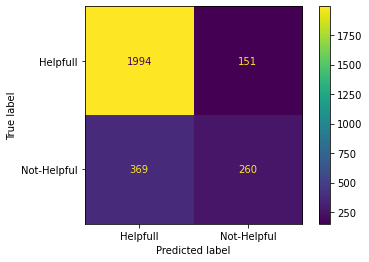

In [59]:
# calculate the confusion matrix
cm_KNN = confusion_matrix(test_target_help, predicted_KNN_help)
# display it graphically
cmd = ConfusionMatrixDisplay(cm_KNN, display_labels=target_categories_help)
cmd.plot();

**Comment:** Now, for our train and test split, we can see that the **accuracy is 81.3%** for KNN while the precision is lower for the Not-Helpful class, possibly because the number of Not-Helpful must be lower than the number of Helpful, or perhaps if the deciding percentage was lower, it would have been quite similar. The confusion matrix demonstrates this; we can see that the Helpful class is dominating here and that a greater percentage as a cut-off indicates that the majority of the evaluations were helpful.

### Pipeline Classification- SVM<br>
Pipeline helps in doing every step together, like data preparation(tokenization) and classification. So below we created a pipeline using the SVM classifier and the tokenizer we defined above.

In [60]:
#Pipeline using SVM
pipeline_SVM_help = Pipeline([
    ('vec', TfidfVectorizer(stop_words="english", min_df = 10, tokenizer=lemma_tokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])

In [61]:
#fit SVM model
pipeline_SVM_help.fit(train_data_help, train_target_help)

Pipeline(steps=[('vec',
                 TfidfVectorizer(min_df=10, stop_words='english',
                                 tokenizer=<function lemma_tokenizer at 0x000001C8078C23A0>)),
                ('tfidf', TfidfTransformer()), ('clf', SGDClassifier())])

In [62]:
#predict SVM model
predicted_SVM_help = pipeline_SVM_help.predict(test_data_help)
print("Classification accuracy = %.3f" % accuracy_score(test_target_help, predicted_SVM_help))

Classification accuracy = 0.838


In [63]:
# classification report to show all the accuracy metrics
print(classification_report(test_target_help, predicted_SVM_help, target_names=target_categories_help))

              precision    recall  f1-score   support

    Helpfull       0.86      0.95      0.90      2145
 Not-Helpful       0.72      0.46      0.57       629

    accuracy                           0.84      2774
   macro avg       0.79      0.71      0.73      2774
weighted avg       0.83      0.84      0.82      2774



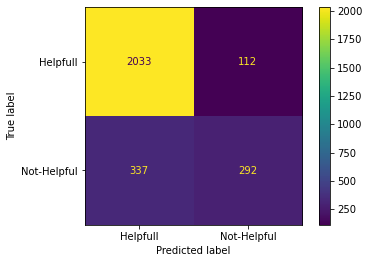

In [64]:
# calculate the confusion matrix
cm_SVM = confusion_matrix(test_target_help, predicted_SVM_help)
# display it graphically
cmd = ConfusionMatrixDisplay(cm_SVM, display_labels=target_categories_help)
cmd.plot();

Same as sentiment Analysis, SVM worked better than KNN while analyzing Helpfulness for this dataset. The **accuracy is 83.8%**, and we can see that it predicted the "Not-helpful" class more accurately.

There are other classifications as well which we can try and test to see which fits better to our data set, we will be using the same tokenizer, ie. lemming, and same vectorizer that is TFIDF.

### Pipeline Classification- Logistic Regression

In [65]:
#Pipeline using Logistic regression
pipeline_LR = Pipeline([
    ('vec', TfidfVectorizer(stop_words="english", min_df = 10, tokenizer=lemma_tokenizer)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(random_state=0))
])

In [66]:
#Logistic regression fit
pipeline_LR.fit(train_data_help, train_target_help)

Pipeline(steps=[('vec',
                 TfidfVectorizer(min_df=10, stop_words='english',
                                 tokenizer=<function lemma_tokenizer at 0x000001C8078C23A0>)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(random_state=0))])

In [67]:
#Logistic regression prediction
predicted_LR_Help = pipeline_LR.predict(test_data_help)
print("Classification accuracy = %.3f" % accuracy_score(test_target_help, predicted_LR_Help))

Classification accuracy = 0.822


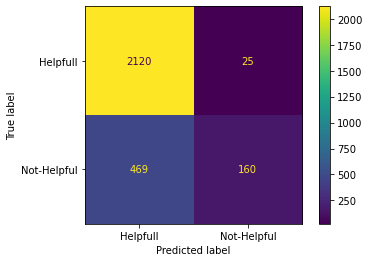

In [68]:
# calculate the confusion matrix
cm_LR = confusion_matrix(test_target_help, predicted_LR_Help)
# display it graphically
cmd = ConfusionMatrixDisplay(cm_LR, display_labels=target_categories_help)
cmd.plot();

We can see that, Logistic Regression accuracy was less than SVM but greater than KNN.

**Sentiment and Helpfulness Comparison:** We can see that KNN performed more accurately for helpfulness analysis than sentiment analysis, while SVM performed better for Sentiment Analysis than helpfulness, which may be attributed to three factors: a high train-test split %, the usage of TFIDvectorizer, and the use of lemming as a tokenization method. <br>
**We may even claim that the number of positive ratings is exactly related to the helpfulness quotient because more ratings equal more help.**

Few comparison points for different types of Classifiers:
1. SVM performed best in all the cases, as SVM usually deals with creating boundaries that works best for text classifications
2. KNN and Logistic Regression also had good accuracies but they would work best with models where there are dependent variables.
3. KNN is easy to model while others are complex models.

## Conclusion:

### Accuracy Comparision for Sentiment and Helpfulness Analysis:

| Classifiers      | Sentiment Analysis | Helpfulness Analysis |
| ----------- | ----------- |-----------------|
| KNN      | Less       | More |
| SVM   | More       | Less |

1. TFIDFVectorization is better than CountVectorization.
2. Lemming is better than Stemming.
3. SVM performed the best for both data sets.
4. Train-test split of 30% gave more accuracy for KNN
5. Cross-fold validation gave less accuracy than the hold-out strategy.
6. Cross-fold validation with more folds will give a more accurate model but a not ideal scenario that may work better for larger data sets.